In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [3]:
# 青海省部分地区
# roi = ee.Geometry.Rectangle([89.852623, 33.737942,93.1677, 36.217184])
# Map.addLayer(roi, {}, "roi")
# Map.centerObject(roi,7)

china_city = ee.FeatureCollection('users/311605001111/ChinaCity')
roi = china_city.filter(ee.Filter.eq('市','武汉市'))
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,6)

# bd = roi.first().geometry().bounds()
# print(bd.getInfo())

In [4]:
# 去云、云阴影、雪掩膜函数
def maskL8sr(image):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    return image.updateMask(mask)

visParams = {
    'bands': ['B5', 'B6', 'B4'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4,
}

# AWEI(自动水体提取指数): AWEIsh = B2 + 2.5B3 - 1.5(B5+B6) - 0.25B7
def water_index(image):
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI") 
    ndvi_mndwi = ndvi.subtract(mndwi).rename('ndvi_mndwi')
    awei = image.expression('B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    return image.addBands(ndvi_mndwi).addBands(ndvi).addBands(mndwi).addBands(awei)

def area_after_clip(image):
    image_area = image.clip(roi).select('B2').gt(0).multiply(ee.Image.pixelArea()).divide(1e6)
    areas = image_area.reduceRegion(**{
        'reducer': ee.Reducer.sum(),
        'geometry': image.geometry(),
        'scale': 30,
        'maxPixels': 1e14
    })
    return image.set({'area': areas.get('B2')})

In [5]:
landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-01-01', '2018-12-31') \
    .map(maskL8sr) \
    .map(water_index)
Map.addLayer(landsat_images.mosaic().clip(roi),visParams,'landsat image')
print(landsat_images.size().getInfo())

69


# 筛选得出采样影像

In [6]:
image_area = landsat_images.mosaic().clip(roi).select('B2').gt(0).multiply(ee.Image.pixelArea()).divide(1e6)
areas = image_area.reduceRegion(**{
    'reducer': ee.Reducer.sum(),
    'geometry': roi,
    'scale': 30,
    'maxPixels': 1e14
})
# print(areas.getInfo())

# 筛选影像，影像覆盖研究区的范围 > 研究区的1/10
sample_image = landsat_images.map(area_after_clip).filter(ee.Filter.gt('area',ee.Number(areas.get('B2')).divide(ee.Number(10))))
print(sample_image.size().getInfo())

# dates = sample_image.aggregate_array('system:time_start').map(lambda d: ee.Date(d).format('YYYY-MM-dd'))
# print(dates.getInfo())

34


# 样本采集函数的定义

In [7]:
# ndvi_mndwi水体频率
basemap = ee.Image.constant(0).clip(roi).rename('waterclass')
water_layer = landsat_images.map(lambda i : i.select('ndvi_mndwi').lt(0)).sum()
validPixel_layer = landsat_images.count().select('B3').clip(roi).rename('count')
index_waterfrequency = water_layer.select('ndvi_mndwi').divide(validPixel_layer.select('count')).select('ndvi_mndwi').rename('frequency')
index_permanent = index_waterfrequency.gte(0.75).remap([0,1],[0,2]).rename('waterclass')
index_season= ee.ImageCollection([index_waterfrequency.gte(0.25),index_waterfrequency.lt(0.75)]).sum().eq(2).rename('waterclass')
index_waterclass = ee.ImageCollection([index_permanent,index_season,basemap]).sum()
# Map.addLayer(index_waterfrequency.gte(0.75).selfMask(),{'palette':['green']},"index permanentwater")
# JRC
JRC_2018 = ee.Image("JRC/GSW1_3/YearlyHistory/2018").clip(roi).remap([0,1,2,3],[0,0,1,2]).rename('waterclass')
JRC_waterclass = ee.ImageCollection([JRC_2018,basemap]).sum()
# Maryland
Maryland_2018 = ee.Image('users/311605001111/Maryland_2018').clip(roi).select('b1').rename('waterclass')
Maryland_permanent = Maryland_2018.select('waterclass').gte(75).remap([0,1],[0,2]).rename('waterclass')
Maryland_season= ee.ImageCollection([Maryland_2018.gte(25),Maryland_2018.lt(75)]).sum().eq(2)
Maryland_waterclass = ee.ImageCollection([Maryland_permanent,Maryland_season,basemap]).sum()
# 三者的交集
permanentWaterExtent = ee.ImageCollection([index_waterclass.eq(2),JRC_waterclass.eq(2),Maryland_waterclass.eq(2)]).sum().eq(3)
landExtent = ee.ImageCollection([index_waterclass.eq(0),JRC_waterclass.eq(0),Maryland_waterclass.eq(0)]).sum().eq(3)
seasonWaterExtent = ee.ImageCollection([permanentWaterExtent,landExtent]).sum().remap([0,1],[1,0]).rename('waterclass')
# # 两者的交集
# permanentWaterExtent = ee.ImageCollection([index_waterclass.eq(2),JRC_waterclass.eq(2)]).sum().eq(2)
# landExtent = ee.ImageCollection([index_waterclass.eq(0),JRC_waterclass.eq(0)]).sum().eq(2)
# seasonWaterExtent = ee.ImageCollection([permanentWaterExtent,landExtent]).sum().remap([0,1],[1,0]).rename('waterclass')

In [8]:
def intervalmean(image):
    awei = image.clip(roi).updateMask(seasonWaterExtent).select('AWEI')
    intervalMean = awei.reduceRegion(**{
        'reducer': ee.Reducer.intervalMean(50,100), 
        'geometry': roi, 
        'scale': 30, 
        'bestEffort': True
    })
    return image.set({'mean': intervalMean.get('AWEI')})

In [9]:
a = sample_image.map(intervalmean).aggregate_array('mean')
print(a.getInfo())

[1833.2069358146275, 1277.3482885097844, 2001.1792807352524, 765.2368731568886, 351.3628022348106, 491.2422884122179, -242.9414773739835, 475.98724170184164, 339.6912128784412, 615.4008182810105, 832.2111912154784, 1528.241316501871, 1889.6328865433998, 558.5839807379335, 357.14113352128203, -52.5582242690037, 150.72513448037537, 93.82713789812735, -152.9668189197687, 133.8894573334904, -158.27636450894803, 510.3469427302653, 1306.4691488873025, 788.3159603637351, 702.6078083454344, 429.981199467142, 538.9236700297523, 294.01948384809293, 267.6170341199865, 570.3982708178327, 362.69304576620885, 416.154383572605, 763.2107377100701, 837.9305139744538]


In [10]:
# RandomForest预测使用的波段
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','mNDWI','ndvi_mndwi','AWEI']
# 分类标签
label = 'waterclass'
def imageSample(image):
    permanent = permanentWaterExtent.updateMask(image.select('B3').gt(0)).remap([0,1],[0,2]).rename('waterclass')
    land = landExtent.updateMask(image.select('B3').gt(0))
    awei = image.clip(roi).updateMask(seasonWaterExtent).select('AWEI')
    season_class = awei.gt(ee.Image.constant(image.get('mean'))).rename('waterclass')
    seasonalwater_Extent = ee.ImageCollection([season_class,basemap]).sum().remap([0,1],[0,2]).rename('waterclass').clip(image.geometry())
    percentile_waterclass = ee.ImageCollection([permanent,seasonalwater_Extent,land]).sum().remap([0,1,2],[0,0,1]).rename('waterclass')
    water = percentile_waterclass.selfMask().clip(image.geometry())
    nowater = percentile_waterclass.eq(0).selfMask().remap([1],[0]).rename('waterclass').clip(image.geometry())
    water_points = water.sample(**{
        'region': roi,
        'scale': 30,
        'numPixels': 400,
        'seed': 0,
        'geometries': True,
    })
    nowater_points = nowater.sample(**{
        'region': roi,
        'scale': 30,
        'numPixels': 200,
        'seed': 0,
        'geometries': True,
    })
    all_points = water_points.merge(nowater_points)
    sample_points = image.select(bands).sampleRegions(**{
        'collection': all_points,
        'properties': [label],
        'scale': 30,
        'geometries': True,
    })
    return sample_points

In [11]:
# 总的样本点数
points_collection = sample_image.map(intervalmean).map(imageSample).flatten()
print(points_collection.first().getInfo())
print('total sample number:{}'.format(points_collection.size().getInfo()))

# # 水体的样本点数
# samplepoint_water = points_collection.filter(ee.Filter.eq('waterclass',1))
# print('water sample number:{}'.format(samplepoint_water.size().getInfo()))

{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [114.67564868561135, 30.581283003170444]}, 'id': 'LC08_122039_20180111_1_33_0', 'properties': {'AWEI': 2734.5, 'B2': 851, 'B3': 1009, 'B4': 898, 'B5': 305, 'B6': 109, 'B7': 72, 'NDVI': -0.49293431639671326, 'mNDWI': 0.8050089478492737, 'ndvi_mndwi': -1.2979432344436646, 'waterclass': 1}}
total sample number:2906


In [12]:
trainedClassifier = ee.Classifier.smileRandomForest(20).train(points_collection,label,bands)
# train_accuracy = trainedClassifier.confusionMatrix()
# print(train_accuracy.getInfo())
# print(train_accuracy.accuracy().getInfo())
# print(train_accuracy.kappa().getInfo())

#对Landsat-8进行分类
def training(image):
    return image.clip(roi).select(bands).classify(trainedClassifier).eq(1).rename('waterclass')

In [13]:
image2 = water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_122039_20180212'))
Map.addLayer(image2.clip(roi),visParams,'image2')

classify2 = image2.clip(roi).select(bands).classify(trainedClassifier).eq(1).rename('waterclass')
Map.addLayer(classify2.selfMask(),{'palette':['blue']}, 'classify2')

In [14]:
image9 = water_index(ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_123039_20180915'))
Map.addLayer(image9.clip(roi),visParams,'image9')

classify9 = image9.clip(roi).select(bands).classify(trainedClassifier).eq(1).rename('waterclass')
Map.addLayer(classify9.selfMask(),{'palette':['blue']}, 'classify9')

Text(0.5, 1.0, 'AWEI(avg(50%-100%))')

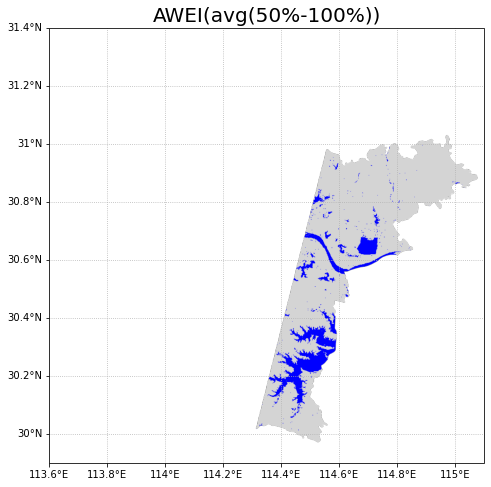

In [23]:
# 制图
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
region = [113.6, 29.9, 115.1, 31.4]
vis = {'palette':['D4D4D4','blue'],'min':0,'max':1}
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(classify2, region=region, vis_params=vis)
# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.2,0.2], linestyle=":")
ax.set_title(label = 'AWEI(avg(50%-100%))', fontsize=20)

In [ ]:
basemap = ee.Image.constant(0).clip(roi).rename('waterclass')
Map.addLayer(basemap,{'palette':['white']},"basemap")

waterpixel_count = landsat_images.map(training).sum()
Map.addLayer(waterpixel_count,{'palette':['white','#e40775'],'min':0,'max':35},"waterPixelCount")

In [ ]:
validPixel = landsat_images.count().select('B3').clip(roi).rename('count')
waterfrequency = waterpixel_count.select('waterclass').divide(validPixel.select('count')).rename('frequency')
Map.addLayer(waterfrequency,{'palette':['white','green'],'min':0,'max':1},"frequency")

permanentwater = waterfrequency.gte(0.75).select('frequency').rename('waterclass')
Map.addLayer(permanentwater.selfMask(),{'palette':['red']},"permanent water")

In [ ]:
# basemap = ee.Image.constant(0).clip(roi).rename('waterclass')
# permanent_water = waterfrequency.gte(0.75).remap([0,1],[0,2]).rename('waterclass')
# seasonal_water = ee.ImageCollection([waterfrequency.gte(0.25),waterfrequency.lt(0.75)]).sum().eq(2).rename('waterclass')
# water_waterclass = ee.ImageCollection([permanent_water,seasonal_water,basemap]).sum()
# # Map.addLayer(water_waterclass,{'palette':['white','red','blue'],'min':0,'max':2},"water waterclass")